In [1]:
import math
import numpy as np
from matplotlib import pyplot
import scipy.optimize as opt

Logistic regression is a statistical model widely used in Machine Learning to predict outcome that can be classified into well defined groups.
For instance: pass/fail, healhy/sick, win/lose etc. It can be also used to classify events - for example, determine whether the image contains specific object (i.e. dog).

Because it makes more sense to have a function (model) which values are between 0 and 1, sigmoid function is used as a basic model for prediction outcome.

\begin{align}
g(z) = \dfrac{1}{1 + e^{-z}}
\end{align}

Drawing a sigmoid function in Python is easy:

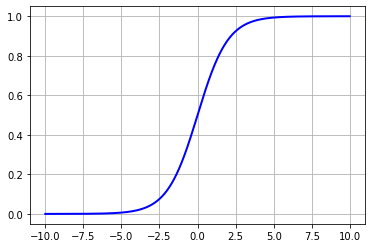

In [2]:
rand_z = np.arange(-10., 10., 0.01)
g = lambda z: 1 / (1 + np.power(math.e, (-z)))
calc_g = [g(z) for z in rand_z]

pyplot.plot(rand_z, calc_g, color='b', lw=2)
pyplot.gca().grid()

In the simplest form, everything above value 0.5 is considered to fit the model.
Let's import data from CSV file - it was provided as part of a great Andrew Ng's course on coursera. It contains three columns:
- Column 1: Result (in %) from first exam
- Column 2: Result (in %) from second exam
- Column 3: 1 (Accepted) or 0 (Rejected) - indicator whether student got admitted into Uni (based on exam results)


In [3]:
microchip_results = np.genfromtxt('microchip_test_results.csv', delimiter=',')
X = microchip_results[:, [0,1]] # <-- Dataset
X = np.concatenate((np.ones((118, 1)), X), axis = 1) # <-- Dataset with 1 added as a first X value
y = microchip_results[:, [2]] # <-- Actual outcome

Plotting this dataset might be a bit trickier as we need two separate indicators - one for microchips that passed the test and the other one for the ones that failed the test.

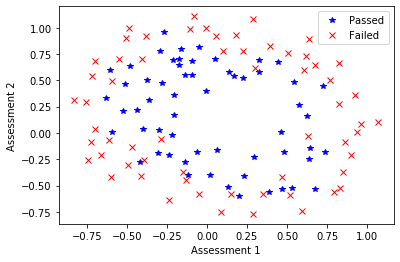

In [4]:
def plot_dataset():
    positive_X = microchip_results[microchip_results[:, -1] == 1][:, [0, 1]]
    negative_X = microchip_results[microchip_results[:, -1] == 0][:, [0, 1]]
    positive_X_chip_1 = positive_X[:,[0]]
    positive_X_chip_2 = positive_X[:,[1]]
    negative_X_chip_1 = negative_X[:,[0]]
    negative_X_chip_2 = negative_X[:,[1]]
    
    
    pyplot.plot(positive_X_chip_1, positive_X_chip_2, '*b', label='Passed')
    pyplot.plot(negative_X_chip_1, negative_X_chip_2, 'xr', label='Failed')
    pyplot.legend(loc='upper right')
    pyplot.xlabel('Assessment 1')
    pyplot.ylabel('Assessment 2')
plot_dataset()

Before we move on, we need to introduce **feature mapping** - a function that maps a data vector into feature space.

This will allow us to draw a function that will better suit our dataset predictions.

In [5]:
def map_features(X1, X2):
    degree = 6
    out = np.ones(X.shape[0])[:,np.newaxis]
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))[:,np.newaxis]))
    return out

X = map_features(X[:,1], X[:,2])

Let's now take a look at some mathematics behind logistic regression.

\begin{align}
h = g(X\theta)
\end{align}

We defined $g$ previously - it is a sigmoid function and $\theta$ is a vector o theta values we want to discover.

Vectorized (and regularized) cost function $J$ looks like this:

\begin{align}
J(\theta) = \dfrac{1}{m} \sum\limits_{i=1}^{m}[-y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}))] + \dfrac{\lambda}{2m}\sum\limits_{j=1}^{n} \theta_{j}^{2}
\end{align}

Below is Python code for calculating $J(\theta)$

In [6]:
thetas = np.zeros([np.size(X[0]), 1])
LAMBDA = .5
m = np.shape(X)[0]
h0x = g(X.dot(thetas)).reshape(118, 1)
J = (1 / m) * np.sum((-y * np.log(h0x)) - (1 - y) * np.log(1 - h0x)) + LAMBDA / 2 * m * sum(np.power(thetas, 2))

...and for calculating derivitive $\theta$ we need to use the following mathematical formula:

\begin{align}
\frac{\partial J(\theta)}{\partial \theta_{j}} = \dfrac{1}{m} \sum\limits_{i=1}^{m}(h_{\theta}(x^{i}) - y^{i})x_{j}^{(i)}
\end{align}

Please note that we are just calculating partial derivative of the gradient.

Vectorized formula:

\begin{align}
\theta = \dfrac{1}{m}X^{T}(g(X\theta) - y)
\end{align}


Actual gradient value will by calculated using 3rd party library (SciPy).

In [7]:
grad = (1 / m) * X.transpose().dot(h0x - y) + (LAMBDA / m) * thetas
grad[0:1] = ((1 / m) * X.transpose().dot(h0x - y))[0:1]

Let's combine gradiet and cost calculations into functions:

In [8]:
def cost_function_reg(thetas, X, y, LAMBDA):
    y = y.reshape(118, 1)
    thetas = thetas.reshape(28, 1)
    h0x = g(X.dot(thetas)).reshape(118, 1)
    m = np.shape(X)[0]
    temp_cost =  (1 / m) * np.sum((-y * np.log(h0x)) - (1 - y) * np.log(1 - h0x)) + (LAMBDA / (2 * m)) * sum(np.power(thetas[1:], 2))    
    temp_grad = ((1 / m) * X.transpose().dot(h0x - y)) + (LAMBDA / m) * thetas
    temp_grad[0:1] = ((1 / m) * X.transpose().dot(h0x - y))[0:1]
    return (temp_cost, temp_grad)

Now, let's minimize function using SciPy library:

In [9]:
thetas = np.zeros(X.shape[1]).reshape(28, 1)
thetas = opt.fmin_tnc(func = cost_function_reg, x0 = thetas.flatten(), args = (X, y.flatten(), LAMBDA))[0]

With calculated thetas we can plot a function.

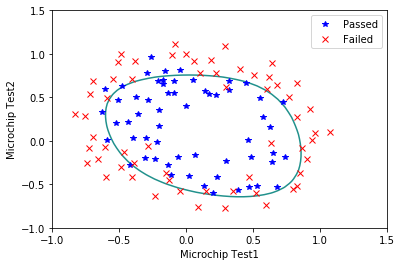

In [11]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def map_feature_for_plotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(map_feature_for_plotting(u[i], v[j]), thetas)

plot_dataset()
pyplot.contour(u,v,z,0)
pyplot.xlabel('Microchip Test1')
pyplot.ylabel('Microchip Test2')
pyplot.show()